In [8]:
from google.colab import drive
import pandas as pd
import os
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from collections import defaultdict
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import transformers
from pathlib import Path
import pickle
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
from abc import ABC, abstractmethod
import random
from statistics import mode
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [9]:
mount_directory = "/content/drive"
dataset_path = os.path.join(mount_directory, 'MyDrive/MELD/MELD_train_efr.json')
model_card = 'bert-base-uncased'
drive.mount(mount_directory)
initial_seed = 2
seeds = [42, 53, 146, 34, 21]

Mounted at /content/drive


## Preprocessing Steps

1. **Mapping Speakers to Occurrence Order**
   
   This step involves assigning a unique identifier to each speaker based on their order of appearance in the dialogue.

2. **Replacing None Values in Triggers with 0**
   
   In this stage, any missing trigger values are substituted with 0 to maintain consistency and facilitate further analysis.

3. **Converting Emotions into One-Hot Encodings**
   
   Emotions expressed in the dialogue are transformed into one-hot encodings, enabling a structured representation for emotion analysis.

4. **Tokenizing the Dialogues**
   
   Dialogues are tokenized to break them down into individual units such as words or subwords, facilitating subsequent processing.

5. **Adding Padding**
   
   To ensure uniformity in sequence lengths, padding is applied to the tokenized dialogues, enabling streamlined input handling for models.





In [10]:
# Mapping Speakers to Occurrence Order
def map_to_order_of_occurrence(data: list) -> list:
    """
    Assigns a unique occurrence order to each speaker based on their appearance in the dialogue.
    Args:
        data (list): A list of speakers in the dialogue.
    Returns:
        list: A list containing the occurrence order of each speaker.
    """
    # Initialize a defaultdict to store the occurrence order of speakers
    dict_order_of_occurrence = defaultdict(lambda: len(dict_order_of_occurrence) + 1)

    # Map each speaker to its occurrence order
    order_of_occurrence = [dict_order_of_occurrence[element] for element in data]

    return order_of_occurrence

In [11]:
# Replacing None Values in Triggers with 0
def replace_none_with_zero(data: list) -> list:
    return [0 if x is None else x for x in data]

In [12]:
# Converting Emotions into One-Hot Encodings
def fit_onehotencoder(data: pd.core.series.Series) -> LabelBinarizer:
  onehotencoder = LabelBinarizer()
  data_flattened = np.concatenate(data.values)
  onehotencoder.fit(data_flattened)
  return onehotencoder

In [13]:
# Tokenizing the Dialogues
def tokenize_dialogue(dialogue_text: list, tokenizer,  speakers = None) -> list:
    """
    Tokenizes a list of dialogue utterances using a given tokenizer.

    Args:
        dialogue_text (list): A list of dialogue utterances.
        tokenizer: Tokenizer object to use for tokenization.
        speakers (list or None): A list of speakers corresponding to each utterance. Defaults to None.

    Returns:
        list: A list of tokenized dialogue utterances.

    Note:
        - If `speakers` is provided, each tokenized utterance will be prefixed with its corresponding speaker.
        - Tokenization includes adding special token [CLS] at the start of the dialogue and [SEP] token at the end of each utterance
    """
    if speakers != None:
        # Tokenize each utterance in the dialogue_text list and prepend speaker if provided.
        tokenized_dialogue = [[speakers[idx]] + tokenizer.tokenize(utterance) + [tokenizer.sep_token] for idx, utterance in enumerate(dialogue_text)]
    else:
        # Tokenize each utterance in the dialogue_text list.
        tokenized_dialogue = [tokenizer.tokenize(utterance) + [tokenizer.sep_token] for utterance in dialogue_text]

    # Insert [CLS] token at the start of the tokenized dialogue.
    tokenized_dialogue.insert(0, [tokenizer.cls_token])

    # Flatten the tokenized dialogue list.
    flattened_tokens = [token for sublist in tokenized_dialogue for token in sublist]
    return flattened_tokens

In [14]:
# Adding Padding
def add_padding(x: list, max_x_length: int, pad_value, pad_length = None) -> list:
    x_length = len(x)
    num_pad_values = max_x_length - x_length

    # If pad_length is not specified, pad each element of x with pad_value.
    if pad_length == None:
        padded_x = x + [pad_value] * num_pad_values
    else:
        # Create a list of pad_length elements with pad_value.
        pad_list = [pad_value] * pad_length

        # Create a 2D numpy array of pad_list repeated num_pad_values times.
        pad_lists = np.tile(pad_list, (num_pad_values, 1))

        # Concatenate x and pad_lists along the first axis to pad each element of x.
        padded_x = np.concatenate((x, pad_lists), axis=0)

    return padded_x

In [15]:
def build_alternative_dialogue(utterances: pd.core.series.Series, speakers: pd.core.series.Series, tokenizer) -> pd.core.series.Series:
    """
    Builds alternative dialogue representations in which the speaker information is incorporated.
    This is used to prepare the dataset for the bert-based baseline models.

    Args:
        utterances (pd.core.series.Series): A series containing dialogue utterances.
        speakers (pd.core.series.Series): A series containing speaker information corresponding to each dialogue.
        tokenizer: Tokenizer object to use for tokenization.

    Returns:
        pd.core.series.Series: A series containing tokenized dialogue representations.
    """
    dialogue_column = []
    for dialogue_index, dialogue in utterances.items():
      dialogue_column.append(tokenize_dialogue(dialogue, tokenizer, speakers[dialogue_index]))
    return pd.Series(dialogue_column)

In [16]:
def build_dataframes(df, emotions_encoder, tokenizer):
    """
    Builds standard and alternative dataframes for dialogue processing.

    Args:
        df (pd.DataFrame): Input dataframe containing dialogue information.
        emotions_encoder: Encoder for emotions to transform them into one-hot encodings.
        tokenizer: Tokenizer object to use for tokenization.

    Returns:
        tuple: A tuple containing two dataframes - standard and variation.

    Note:
        - Standard dataframe contains tokenized dialogues with mapped speakers, encoded emotions, and triggers.
        - Variation dataframe additionally incorporates alternative dialogue representations.
    """
    column_names = ['emotions', 'speakers', 'triggers', 'dialogues', 'dialogues_ids', 'attention_masks']
    df_standard = pd.DataFrame(columns = column_names)
    df_standard['speakers'] = df['speakers'].apply(lambda x: map_to_order_of_occurrence(x))
    df_standard['emotions'] = df['emotions'].apply(lambda x: emotions_encoder.transform(x))
    df_standard['triggers'] = df['triggers'].apply(lambda x: replace_none_with_zero(x))
    df_variation = copy.deepcopy(df_standard)
    df_standard['dialogues'] = df['utterances'].apply(lambda x: tokenize_dialogue(x, tokenizer))
    df_variation['dialogues'] = build_alternative_dialogue(df['utterances'], df_standard['speakers'], tokenizer)
    return df_standard, df_variation

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
tokenizer = BertTokenizer.from_pretrained(model_card, do_lower_case=True)
df = pd.read_json(dataset_path)
emotions_onehotencoder = fit_onehotencoder(df['emotions'])
df_standard, df_variation = build_dataframes(df, emotions_onehotencoder, tokenizer)

cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
num_emotions =  len(emotions_onehotencoder.classes_)
max_num_utterances = df['utterances'].apply(len).max()

In [19]:
class CustomDataset(Dataset):
    def __init__(self, speakers: pd.core.series.Series,
                 dialogues:  pd.core.series.Series,
                 emotions:  pd.core.series.Series,
                 triggers:  pd.core.series.Series,
                 device,
                 pad_token: str,
                 max_num_utterances):
        """
        Initializes a custom PyTorch dataset for dialogue processing.

        Args:
            speakers (pd.core.series.Series): Series containing speaker information.
            dialogues (pd.core.series.Series): Series containing dialogue utterances.
            emotions (pd.core.series.Series): Series containing emotion information.
            triggers (pd.core.series.Series): Series containing trigger information.
            device: PyTorch device to store the tensors.
            pad_token (str): Token to use for padding dialogue sequences.
            max_num_utterances (int): Maximum number of utterances to consider in a dialogue.

        Note:
            - The dataset preprocesses dialogues, speakers, emotions, and triggers with padding.
            - For each dialogue, a sequence of padding tokens is added to match the length of the longest dialogue in the dataset.
            - For each dialogue, dialogue ids and dialogue mask are created using the tokenizer.
            - For each speakers instance, a sequence of zeros is appended to align with the maximum number of utterances in any dialogue.
            - For each emotions instance, a sequence of arrays of zeros is appended to align with the maximum number of utterances in any dialogue.
            - For each triggers instance, a sequence of zeros is appended to align with the maximum number of utterances in any dialogue.
        """
        self.max_dialogue_length = dialogues.apply(len).max()
        self.max_num_utterances = max_num_utterances
        self.dialogues = dialogues.apply(lambda x: add_padding(x, self.max_dialogue_length, pad_token))
        self.dialogues_ids = self.dialogues.apply(lambda x: tokenizer.convert_tokens_to_ids(x))
        self.attention_masks = self.dialogues.apply(lambda x: [1 if token != pad_token else 0 for token in x])
        self.speakers = speakers.apply(lambda x: add_padding(x, self.max_num_utterances, pad_value=0))
        num_emotion_classes = len(emotions[0][0])
        self.emotions = emotions.apply(lambda x: add_padding(x, self.max_num_utterances, pad_value = 0, pad_length = num_emotion_classes))
        self.triggers = triggers.apply(lambda x: add_padding(x, self.max_num_utterances, pad_value=0))
        self.device = device

    def __len__(self):
        return len(self.dialogues)

    def __getitem__(self, idx):
        """
        Retrieves a single data instance from the dataset.

        Args:
            idx (int): Index of the data instance.

        Returns:
            tuple: A tuple containing tensors for speakers, dialogue IDs, dialogue masks, emotions, and triggers.
        """
        speakers = torch.tensor(self.speakers.iloc[idx], dtype=torch.long).to(device)
        dialogues_ids = torch.tensor(self.dialogues_ids.iloc[idx], dtype=torch.long).to(device)
        dialogues_masks =  torch.tensor(self.attention_masks.iloc[idx], dtype=torch.long).to(device)
        emotions = torch.tensor(self.emotions.iloc[idx], dtype=torch.float32).to(device)
        triggers = torch.tensor(self.triggers.iloc[idx], dtype=torch.float32).to(device)
        return  speakers, dialogues_ids, dialogues_masks, emotions, triggers

In [20]:
def create_dataloader(df: pd.core.frame.DataFrame, device, tokenizer, max_num_utterances, batch_size) -> torch.utils.data.dataloader.DataLoader :
    dataset =  CustomDataset(speakers = df['speakers'],
                                dialogues = df['dialogues'],
                                emotions = df['emotions'],
                                triggers = df['triggers'],
                                device = device,
                                pad_token = tokenizer.pad_token,
                                max_num_utterances = max_num_utterances)
    return DataLoader(dataset, batch_size = batch_size, shuffle = True)

# STATISTICS
In this section, we delve into gaining insights into the distribution of our dataset. Specifically, we examine the distribution of dialogue length, the number of utterances in a dialogue, and the number of speakers in a dialogue. Additionally, we visualize the distribution of emotion labels and trigger labels to better comprehend the data imbalance, particularly focusing on the distribution of emotion labels.

In [81]:
def plot_hist(data, num_bins, xlabel, ylabel, title):
    plt.hist(data, bins=num_bins, edgecolor='black')

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Show plot
    plt.show()

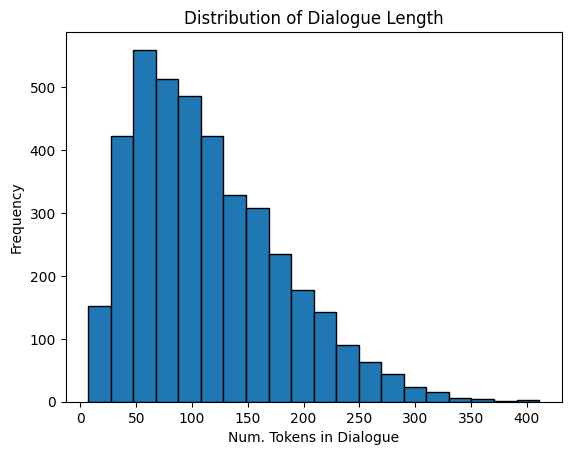

Max number of tokens in a dialogue is 411


In [92]:
lens = df_standard['dialogues'].apply(len)
plot_hist(lens, num_bins = 20,
          xlabel = 'Num. Tokens in Dialogue',
          ylabel = 'Frequency',
          title = 'Distribution of Dialogue Length')
print('Max number of tokens in a dialogue is {max_num}'.format(max_num = lens.max()))

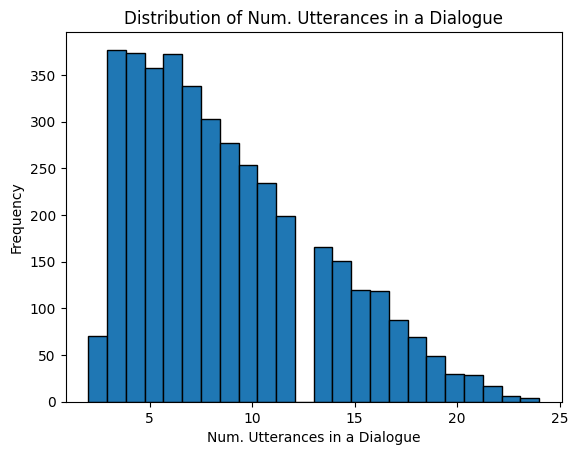

Max number of utterances in a dialogue is 24


In [91]:
num_utterances = df_standard['speakers'].apply(len)
plot_hist(num_utterances, num_bins = 24,
          xlabel = 'Num. Utterances in a Dialogue',
          ylabel = 'Frequency',
          title = 'Distribution of Num. Utterances in a Dialogue')
print('Max number of utterances in a dialogue is {max_num}'.format(max_num = num_utterances.max()))

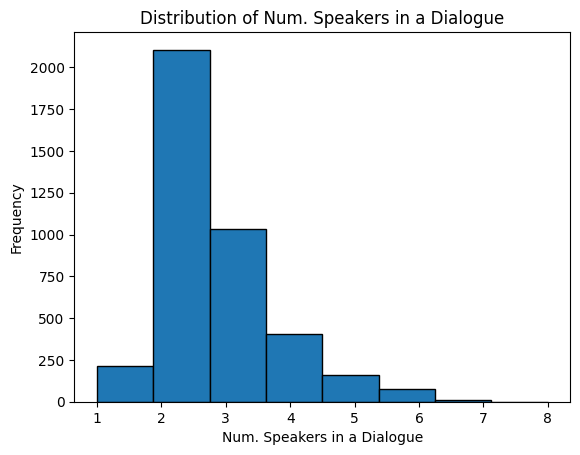

Max number of speakers in a dialogue is 8


In [90]:
num_speakers = df_standard['speakers'].apply(lambda x: max(x))
plot_hist(num_speakers, num_bins = 8,
          xlabel = 'Num. Speakers in a Dialogue',
          ylabel = 'Frequency',
          title = 'Distribution of Num. Speakers in a Dialogue')
print('Max number of speakers in a dialogue is {max_num}'.format(max_num = num_speakers.max()))

In [117]:
def plot_from_counts(counts, xlabel, title):
  x_labels = []
  y_values = []
  for data, count in counts.items():
    x_labels.append(str(data))
    y_values.append(count)
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  plt.bar(x_labels, y_values, color='skyblue')

  # Add labels and title
  plt.xlabel(xlabel)
  plt.ylabel('Count')
  plt.title(title)

  # Show plot
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent clipping of labels
  plt.show()

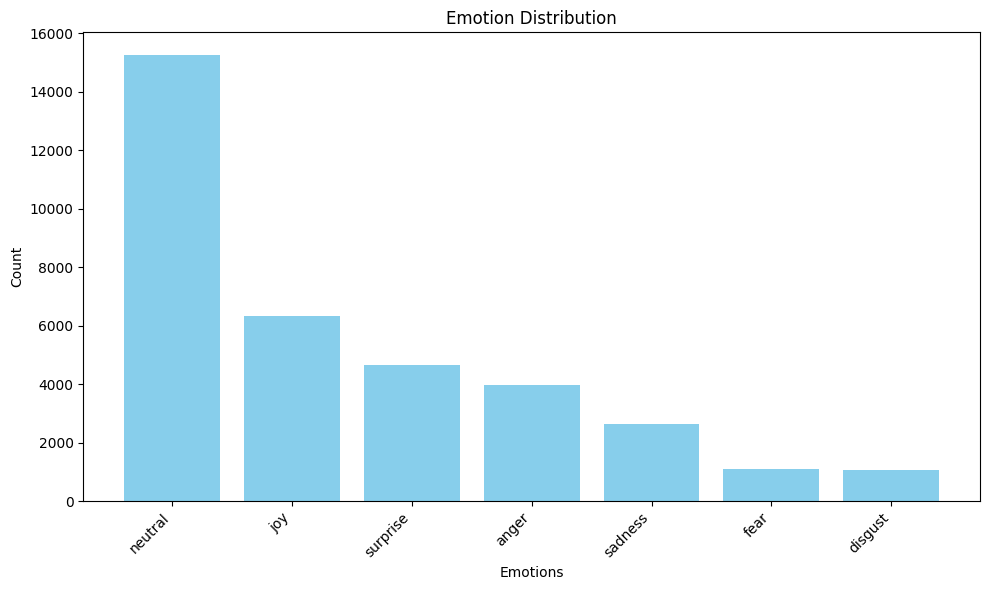

In [118]:
df_emotions_flattened  = [emotion for dialogues in df['emotions'] for emotion in dialogues]
df_emotions_series = pd.Series(df_emotions_flattened)
emotion_counts = df_emotions_series.value_counts()
plot_from_counts(emotion_counts, xlabel='Emotions', title='Emotion Distribution')

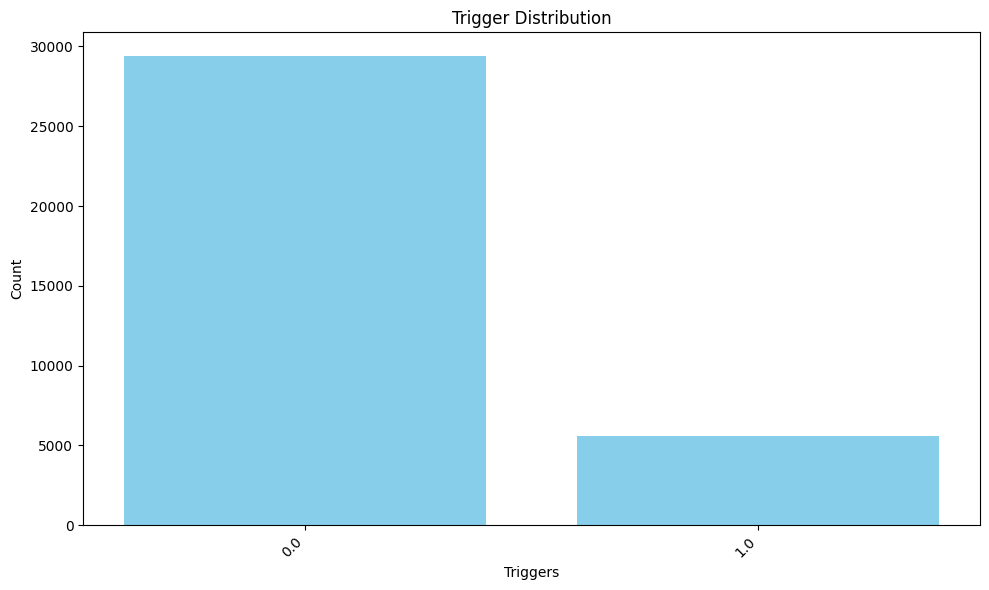

In [120]:
df_triggers_flattened  = [trigger for dialogues in df['triggers'] for trigger in dialogues]
df_triggers_series = pd.Series(df_triggers_flattened)
triggers_counts = df_triggers_series.value_counts()
plot_from_counts(triggers_counts, xlabel='Triggers', title='Trigger Distribution')

# Models Definition

Several models have been defined for emotion and trigger prediction:

1. **Custom Model**: Combines a BERT model with a GRU (Gated Recurrent Unit) on top. The predicted emotion is used to help the model in predicting the trigger value.

2. **BERT-based Baseline Model**: Utilizes a pre-trained BERT model as the backbone and adds two classifiers on top for predicting emotions and triggers independently.

3. **Majority Classifier**: Always predicts the emotion and trigger values that appear most frequently in the dataset. This serves as a simple baseline for comparison.

4. **Random Classifier**: Outputs random emotions and trigger values. This model is useful as another baseline for evaluating performance.


In [ ]:
class AbstractModel(ABC, torch.nn.Module):
    """
    Abstract base class for defining emotion and trigger prediction models.

    Attributes:
        num_emotions (int): Number of emotion classes.
        max_num_utterances (int): Maximum number of utterances in a dialogue.
        device: PyTorch device to store the tensors.
    """
    def __init__(self, num_emotions, max_num_utterances, device):
        """
        Initializes the abstract model.

        Args:
            num_emotions (int): Number of emotion classes.
            max_num_utterances (int): Maximum number of utterances in a dialogue.
            device: PyTorch device to store the tensors.
        """
        super(AbstractModel, self).__init__()
        self.num_emotions = num_emotions
        self.max_num_utterances =max_num_utterances
        self.device = device

    @abstractmethod
    def forward(self, token_type_ids, input_ids, attention_mask, emotions, triggers):
        """
        Abstract method for the forward pass of the model.

        Args:
            token_type_ids: Tensor of token type IDs.
            input_ids: Tensor of input IDs.
            attention_mask: Tensor of attention masks.
            emotions: Tensor of emotion labels.
            triggers: Tensor of trigger labels.
        """
        pass

In [ ]:
class AbstractBERTModel( AbstractModel):
    """
    Abstract base class for BERT-based emotion and trigger prediction models.
    """
    def __init__(self, model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer, gru_hidden_size = None):
        """
        Initializes the abstract BERT model.

        Args:
            model_card: Model configuration card for BERT.
            tokenizer: BERT tokenizer object.
            num_emotions (int): Number of emotion classes.
            max_num_utterances (int): Maximum number of utterances in a dialogue.
            device: PyTorch device to store the tensors.
            freeze_embedding_layer (bool): Whether to freeze the BERT embedding layer.
            gru_hidden_size (int or None): Size of the GRU hidden state.
        """
        super(AbstractBERTModel, self).__init__(num_emotions, max_num_utterances, device)

        self.tokenizer = tokenizer
        self.bert_model = BertModel.from_pretrained(model_card).to(device)
        # If freeze_embedding_layer is set to True, then the Bert embedding layer weights are freezed
        if freeze_embedding_layer:
            self.bert_model.embeddings.requires_grad_(False)
        self.representation_length = self.bert_model.config.hidden_size
        self.emotion_classifier = nn.Sequential(
            nn.Linear(self.representation_length, 1024),
            nn.BatchNorm1d(24),
            torch.nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(24),
            torch.nn.ReLU(),
            nn.Linear(512, self.num_emotions)
        )
        self.gru_hidden_size  = gru_hidden_size
        self.trigger_prediction = self._create_trigger_module()

    @abstractmethod
    def _create_trigger_module(self):
        """
        Abstract method to create the trigger prediction module.
        """
        pass

    def bert_forward(self, input_ids, attention_mask):
        """
        Forward pass through the BERT model to extract [SEP] token representations.

        Args:
            input_ids: Tensor of input IDs.
            attention_mask: Tensor of attention masks.

        Returns:
            Tuple containing [SEP] token representations and dialogue masks.
        """
        # Pass input_ids and attention_mask through the BERT model to obtain last hidden states.
        bert_output_1 = self.bert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # Find indices of [SEP] tokens in the input_ids tensor.
        sep_indices = (input_ids == self.tokenizer.sep_token_id).nonzero()
        batch_size = input_ids.shape[0]

        # Initialize tensors to store [SEP] token representations and dialogue masks.
        sep_representations = torch.zeros((batch_size, self.max_num_utterances, self.representation_length)).to(self.device)
        dialogue_masks = torch.zeros((batch_size, self.max_num_utterances)).to(self.device)

        # Loop through the batch to populate sep_representations and dialogue_masks.
        for idx in range(batch_size):
            # Find indices of [SEP] tokens for the current batch.
            sep_indices_idx = sep_indices[sep_indices[:,0] == idx][:,1]
            sep_indices_idx_range = range(len(sep_indices_idx))

            # Set corresponding elements in dialogue_masks to 1.
            dialogue_masks[idx, sep_indices_idx_range] = 1

            # Extract [SEP] token representations and store them in sep_representations.
            sep_representations[idx, sep_indices_idx_range, :] = bert_output_1[idx, sep_indices_idx, :]

        # Return [SEP] token representations and dialogue masks.
        return sep_representations, dialogue_masks

In [ ]:
class CustomBERTModel(AbstractBERTModel):
    """
    Custom BERT-based model for emotion and trigger prediction.

    Inherits from AbstractBERTModel.

    Attributes:
        linear_trigger: Linear layer for trigger prediction.
    """
    def __init__(self, model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer, gru_hidden_size):
        super(CustomBERTModel, self).__init__(model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer, gru_hidden_size)
        self.linear_trigger = nn.Linear(self.gru_hidden_size * 2, 1)


    def _create_trigger_module(self):
        """
        Creates the trigger prediction module for the Custom model.

        Returns:
            nn.GRU: Bidirectional GRU module for trigger prediction.
        """
        return nn.GRU(
            input_size=self.representation_length + num_emotions + 1,
            hidden_size=self.gru_hidden_size,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, token_type_ids, input_ids, attention_mask, _, __):
        """
        Forward pass of the custom BERT model.
        To predict triggers, it utilizes the sep_representations obtained from the BERT model's forward pass,
        concatenating them with emotion predictions and speaker identifiers.
        This combined input is then fed into a GRU model, followed by a sigmoid layer, to predict the trigger value for each utterance.

        Args:
            token_type_ids: Tensor of token type IDs.
            input_ids: Tensor of input IDs.
            attention_mask: Tensor of attention masks.
            _: Placeholder for emotions (not used).
            __: Placeholder for triggers (not used).

        Returns:
            Tuple containing emotion predictions, trigger predictions, and dialogue masks.
        """
        # Perform forward pass through BERT model to obtain sep_representations and dialogue_masks.
        sep_representations, dialogue_masks = self.bert_forward(input_ids, attention_mask)

        # Pass sep_representations through the emotion classifier and multiply with dialogue_masks to obtain emotion predictions.
        emotion_predictions = (self.emotion_classifier(sep_representations) * dialogue_masks.unsqueeze(-1)).to(self.device)

        # Concatenate sep_representations, emotion predictions, and token_type_ids to form the combined input.
        concatenated_input = torch.cat([sep_representations, emotion_predictions, token_type_ids.unsqueeze(-1)], dim=-1).to(self.device)

        # Pass the concatenated input through the trigger prediction model to obtain trigger predictions.
        trigger_output, _ = self.trigger_prediction(concatenated_input)

        # Apply linear transformation followed by sigmoid activation to obtain single-value trigger predictions.
        trigger_output_single_value = self.linear_trigger(trigger_output.to(self.device)).squeeze(-1).to(self.device)

        # Apply sigmoid activation and mask out padded values to obtain final trigger predictions.
        trigger_output_sigmoid = (torch.sigmoid(trigger_output_single_value) * dialogue_masks).to(self.device)

        # Return emotion predictions, trigger predictions, and dialogue masks.
        return emotion_predictions, trigger_output_sigmoid, dialogue_masks

In [ ]:
class BaselineBERTModel(AbstractBERTModel):
    """
    Baseline BERT-based model for emotion and trigger prediction.

    Inherits from AbstractBERTModel.
    """
    def __init__(self, model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer=False):
        super(BaselineBERTModel, self).__init__(model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer)

    def _create_trigger_module(self):
        """
        Creates the trigger prediction module for the Baseline.

        Returns:
            nn.Sequential: Sequential module for trigger prediction.
        """
        return nn.Sequential(
            nn.Linear(self.representation_length, 512),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, _, input_ids, attention_mask, __, ___):
        """
        Forward pass of the baseline BERT model utilizes sep_representations obtained from the BERT model's forward pass.
        These representations serve as input for two sequential classifiers: one for emotion prediction and the other for trigger prediction.
        Importantly, these classifiers operate independently.

        Args:
            _: Placeholder for speakers (not used).
            input_ids: Tensor of input IDs.
            attention_mask: Tensor of attention masks.
            __: Placeholder for emotions (not used).
            ___: Placeholder for triggers (not used).

        Returns:
            Tuple containing emotion predictions, trigger predictions, and dialogue masks.
        """
        # Perform forward pass through BERT model to obtain sep_representations and dialogue_masks.
        sep_representations, dialogue_masks = self.bert_forward(input_ids, attention_mask)

        # Pass sep_representations through the emotion classifier to obtain emotion predictions.
        emotion_predictions = self.emotion_classifier(sep_representations).to(self.device)

        # Pass sep_representations through the trigger prediction layer to obtain trigger predictions.
        trigger_output = self.trigger_prediction(sep_representations).to(self.device)

        # Squeeze the trigger_output tensor to remove the last dimension.
        trigger_output = trigger_output.squeeze(dim=-1).to(self.device)

        # Return emotion predictions, trigger predictions, and dialogue masks.
        return emotion_predictions, trigger_output, dialogue_masks

In [ ]:
class NoGradClassifier(AbstractModel):
    """
    Classifier model for emotion and trigger prediction without gradient calculation.

    Inherits from AbstractModel.
    """
    def __init__(self, num_emotions , max_num_utterances, device):
        super(NoGradClassifier, self).__init__(num_emotions, max_num_utterances, device)

    @abstractmethod
    def generate_emotion_index(self):
        """
        Abstract method to generate the index of the active emotion.
        """
        pass

    @abstractmethod
    def generate_trigger(self):
        """
        Abstract method to generate the trigger value.
        """
        pass

    def _populate_dialogue_masks(_, dialogue_masks, emotions):
        """
        Populates the dialogue masks based on the presence of emotions.

        Args:
            dialogue_masks: Tensor for dialogue masks.
            emotions: Tensor containing emotion labels.
        """
        for batch_idx, dialogue in enumerate(emotions):
           for utterance_idx, token in enumerate(dialogue):
              if np.any(token.cpu().numpy()):
                dialogue_masks[batch_idx, utterance_idx] = 1
              else:
                dialogue_masks[batch_idx, utterance_idx] = 0

    def forward(self, _, __, ___, emotions, triggers):
        """

        Forward pass of the no-grad classifier model involves predicting an emotion and a trigger value for each utterance.
        These predictions are based on the values returned by generate_emotion_index() and generate_trigger() methods, respectively.

        Args:
            _: Placeholder for speakers (not used).
            __: Placeholder for dialogue IDs (not used).
            ___: Placeholder for attention masks (not used).
            emotions: Tensor of emotion labels.
            triggers: Tensor of trigger labels.

        Returns:
            Tuple containing emotion predictions, trigger predictions, and dialogue masks.
        """
        # Initialize dialogue masks, emotion predictions, and trigger predictions tensors.
        batch_size = emotions.shape[0]
        dialogue_masks = torch.zeros((batch_size, self.max_num_utterances)).to(self.device)
        emotion_pred = torch.zeros((batch_size, self.max_num_utterances, self.num_emotions)).to(self.device)
        trigger_pred = torch.zeros((batch_size, self.max_num_utterances)).to(self.device)

        # Populate dialogue masks based on the number of utterances.
        self._populate_dialogue_masks(dialogue_masks, emotions)

        # Generate emotion and trigger predictions for each utterance in each dialogue.
        for batch_idx, dialogue in enumerate(emotions):
            for utterance_idx, _ in enumerate(dialogue):
                # Generate an emotion index and convert it into one-hot encoding.
                active_index = self.generate_emotion_index()
                one_hot_encoding = np.zeros(self.num_emotions)
                one_hot_encoding[active_index] = 1

                # Assign the one-hot encoding to the corresponding position in the emotion prediction tensor.
                emotion_pred[batch_idx, utterance_idx, :] = torch.tensor(one_hot_encoding)

                # Generate a trigger value.
                trigger_pred[batch_idx, utterance_idx] = self.generate_trigger()

        # Apply dialogue masks to emotion and trigger predictions.
        emotion_pred = (emotion_pred * dialogue_masks.unsqueeze(-1)).to(self.device)
        trigger_pred = (trigger_pred * dialogue_masks).to(self.device)

        # Return emotion predictions, trigger predictions, and dialogue masks.
        return emotion_pred, trigger_pred, dialogue_masks


In [ ]:
class RandomClassifier(NoGradClassifier):
    """
    Classifier model for emotion and trigger prediction with random predictions.

    Inherits from NoGradClassifier.

    Attributes:
        seed (int): Seed for random number generation.
    """
    def __init__(self, num_emotions , max_num_utterances, device, seed):
        super(RandomClassifier, self).__init__(num_emotions, max_num_utterances, device)
        np.random.seed(seed)

    def generate_emotion_index(self):
        """
        Generates a random emotion index.

        Returns:
            int: Random emotion index.
        """
        return np.random.randint(self.num_emotions)

    def generate_trigger(self):
        """
        Generates a random trigger value from a uniform distribution between 0 and 1.

        Returns:
            float: Random trigger value.
        """
        return random.uniform(0, 1)

In [ ]:
class MajorityClassifier(NoGradClassifier):
    """
    Classifier model for emotion and trigger prediction based on majority class.

    Inherits from NoGradClassifier.

    Attributes:
        majority_emotion_index (int): Index of the majority emotion class.
        majority_trigger (float): Majority trigger value.
    """
    def __init__(self, num_emotions , max_num_utterances,device, emotions, triggers):
        super(MajorityClassifier, self).__init__(num_emotions, max_num_utterances, device)
        self.majority_emotion_index = self._compute_majority_emotion_index(emotions)
        self.majority_trigger = self._compute_majority_trigger(triggers)

    def _compute_majority_emotion_index(self,emotions):
        """
        Computes the majority emotion index.

        Args:
            emotions: Tensor containing emotion labels.

        Returns:
            int: Index of the majority emotion class.
        """
        flattened_emotions = self._flatten(emotions)
        flattened_emotions = torch.argmax(flattened_emotions, dim = -1)
        return mode(flattened_emotions)

    def _compute_majority_trigger(self, triggers):
        """
        Computes the majority trigger value.

        Args:
            triggers: Tensor containing trigger labels.

        Returns:
            float: Majority trigger value.
        """
        flattened_triggers = self._flatten(triggers)
        return mode(flattened_triggers)

    def _flatten(self, data):
        flattened_array = []
        for dialogue in data:
          for element in dialogue:
            flattened_array.append(element)
        return torch.tensor(flattened_array).to(self.device)

    def generate_emotion_index(self):
        """
        Returns the computed emotion index based on the majority class.

        Returns:
            int: Majority emotion index.
        """
        return self.majority_emotion_index

    def generate_trigger(self):
        """
        Returns the computed trigger value based on the majority class.

        Returns:
            float: Majority trigger value.
        """
        return self.majority_trigger

In [ ]:
majority_model = MajorityClassifier(num_emotions, max_num_utterances, device, df_standard['emotions'], df_standard['triggers']).to(device)
random_model = RandomClassifier(num_emotions, max_num_utterances, device, seed = initial_seed).to(device)

# TRAINING AND EVALUATION
The CustomTraining class, along with its utility methods, enables the training and evaluation of models for dialogue systems with emotion and trigger prediction capabilities. It provides functionality for computing loss functions, evaluating metrics such as F1 scores, and visualizing confusion matrices. This comprehensive set of tools allows for thorough assessment of model performance during training and validation.








In [ ]:
def remove_pad(batch_idx, target, predictions, dialogue_length):
        """
        Remove padding from target and prediction tensors based on dialogue length.

        Args:
            batch_idx (int): Batch index.
            target (torch.Tensor): Target tensor.
            predictions (torch.Tensor): Prediction tensor.
            dialogue_length (int): Length of the dialogue without padding.

        Returns:
            Tuple containing target and prediction tensors without padding.
        """
        target_nopad = target[batch_idx, :dialogue_length]
        predictions_nopad = predictions[batch_idx, :dialogue_length]
        return target_nopad, predictions_nopad

def remove_pad_predictions(batch_idx, emotions, emotion_predictions, triggers, trigger_predictions, dialogue_mask):
        """
        Remove padding from emotion and trigger predictions based on dialogue length.

        Returns:
            Tuple containing emotion and trigger tensors without padding.
        """
        # Determine the dialogue length without padding.
        dialogue_bool = (dialogue_mask[batch_idx] == 0)
        dialogue_true = dialogue_bool.nonzero()
        if len(dialogue_true) == 0:
          dialogue_length = len(dialogue_mask[batch_idx])
        else:
           dialogue_length = (dialogue_mask[batch_idx] == 0).nonzero()[0][0].item()
        # Remove padding from emotion and trigger predictions using the determined dialogue length.
        emotions_nopad, emotion_pred_nopad = remove_pad(batch_idx, emotions, emotion_predictions, dialogue_length)
        triggers_nopad, trigger_pred_nopad = remove_pad(batch_idx, triggers, trigger_predictions, dialogue_length)
        return emotions_nopad, emotion_pred_nopad, triggers_nopad, trigger_pred_nopad

def update_metric_arrays(emotions_nopad, emotion_pred_nopad, triggers_nopad, triggers_pred_nopad,
                    emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat,
                    f1_seq_emotions, f1_seq_triggers):
        """
        Update metric arrays with emotion and trigger predictions without padding.
        """
        emotions_flat.extend(emotions_nopad.tolist())
        emotions_pred_flat.extend(emotion_pred_nopad.tolist())
        triggers_flat.extend(triggers_nopad.tolist())
        triggers_pred_flat.extend(triggers_pred_nopad.tolist())
        f1_seq_emotions.append(f1_score(emotions_nopad.cpu().numpy(), emotion_pred_nopad.cpu().numpy(), average = 'micro'))
        f1_seq_triggers.append(f1_score(triggers_nopad.cpu().numpy(), triggers_pred_nopad.cpu().numpy(), average = 'micro'))

def get_metric_results(flattened_emotions, flattened_emotions_pred, flattened_triggers, flattened_triggers_pred, f1_sequence_emotions, f1_sequence_triggers):
        """
        Calculate metric results (f1 seq. score and f1 unrolled seq. score for both emotions and triggers) based on emotion and trigger predictions.
        """
        # Calculate the average F1 sequence scores for emotions and triggers.
        avg_f1_sequence_emotion = sum(f1_sequence_emotions) / len(f1_sequence_emotions)
        avg_f1_sequence_trigger = sum(f1_sequence_triggers) / len(f1_sequence_triggers)

        # Calculate the F1 scores for flattened emotions and triggers.
        f1_flattened_emotion = f1_score(flattened_emotions, flattened_emotions_pred, average='micro')
        f1_flattened_trigger = f1_score(flattened_triggers, flattened_triggers_pred, average='micro')
        return avg_f1_sequence_emotion, avg_f1_sequence_trigger, f1_flattened_emotion, f1_flattened_trigger

def turn_into_greedy(emotions, emotion_pred, trigger_pred):
        """
        Convert  emotion and trigger predictions into discrete format.
        """
        return torch.argmax(emotions, dim=-1), torch.argmax(emotion_pred, dim=-1), (trigger_pred > 0.5).float()

def discrete_to_onehot(discrete_values, num_classes):
        """
        Convert discrete values into one-hot encoded format.

        Args:
            discrete_values (torch.Tensor): Discrete values.
            num_classes (int): Number of classes.

        Returns:
            torch.Tensor: One-hot encoded tensor.
        """
        one_hot_encoded = torch.zeros(len(discrete_values), num_classes)
        one_hot_encoded[torch.arange(len(discrete_values)), discrete_values] = 1
        return one_hot_encoded

def show_confusion_matrix(cm, emotions):
        """
        Display confusion matrix.
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=np.unique(emotions),
                    yticklabels=np.unique(emotions))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
class CustomTraining():
    def __init__(self, training_loader,validation_loader,test_loader,  device: str,epochs=15,seed=42, onehotencoder= None):
        """
        Initialize the CustomTraining object.

        Args:
            training_loader (DataLoader): DataLoader for training data.
            validation_loader (DataLoader): DataLoader for validation data.
            test_loader (DataLoader): DataLoader for test data.
            device (str): Device to run the training on (e.g., 'cpu', 'cuda').
            epochs (int): Number of epochs for training. Default is 15.
            seed (int): Random seed for reproducibility. Default is 42.
            onehotencoder: OneHotEncoder object for transforming labels.
        """
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.device = device
        self.seed = seed
        self.onehotencoder = onehotencoder

    def compute_loss(self, emotion_pred, emotions, trigger_pred, triggers, dialogue_mask):
        """
        Compute the loss function.

        For each dialogue in the batch, this method calculates the Binary Cross Entropy Loss for predicted triggers
        compared to the target triggers and the Categorical Cross Entropy Loss for predicted emotions compared to the target ones.
        The final loss is the sum of the average emotion loss and the average trigger loss computed over the batch.

        Args:
            emotion_pred (Tensor): Predicted emotions from the model.
            emotions (Tensor): Target emotions.
            trigger_pred (Tensor): Predicted triggers from the model.
            triggers (Tensor): Target triggers.
            dialogue_mask (Tensor): Mask to indicate the dialogue lengths.

        Returns:
            Tensor: The computed loss.
        """
        # Initialize variables for accumulating losses
        N = 0
        total_emotions_loss = 0
        total_triggers_loss = 0

        # Iterate over each dialogue in the batch
        for batch_idx in range(emotion_pred.size(0)):
            # Remove padding from predictions and targets
            emotions_nopad, emotion_pred_nopad, triggers_nopad, triggers_pred_nopad = remove_pad_predictions(
                batch_idx, emotions, emotion_pred, triggers, trigger_pred, dialogue_mask)

            # Convert emotions to discrete values
            discrete_emotions = torch.argmax(emotions_nopad, dim=-1).to(self.device)

            # Update the total number of samples
            N = N + triggers_nopad.size(0)

            # Compute losses for emotions and triggers
            emotions_loss = torch.nn.CrossEntropyLoss(reduction='sum')(emotion_pred_nopad, discrete_emotions)
            triggers_loss = torch.nn.BCELoss(reduction='sum')(triggers_pred_nopad, triggers_nopad)

            # Accumulate losses
            total_emotions_loss += emotions_loss
            total_triggers_loss += triggers_loss

        # Calculate mean losses
        mean_emotions_loss = total_emotions_loss / N
        mean_triggers_loss = total_triggers_loss / N

        # Compute the final loss
        loss = mean_emotions_loss + mean_triggers_loss

        return loss.to(self.device)

    def _compute_metrics(_, emotions, emotion_pred, triggers, trigger_pred, dialogue_mask,emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers):
            emotions, emotion_pred , trigger_pred = turn_into_greedy(emotions, emotion_pred, trigger_pred)
            for batch_idx in range(emotion_pred.size(0)):
                emotions_nopad, emotion_pred_nopad, triggers_nopad, triggers_pred_nopad = remove_pad_predictions(batch_idx,emotions,emotion_pred,triggers,trigger_pred,dialogue_mask)
                update_metric_arrays(emotions_nopad, emotion_pred_nopad, triggers_nopad, triggers_pred_nopad,emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat,f1_sequence_emotions, f1_sequence_triggers)

    def _set_loop_info(self,  loop, loss, avg_loss, avg_f1_sequence_emotion, f1_flattened_emotion, avg_f1_sequence_trigger, f1_flattened_trigger):
            loop.set_description(f'Train set.')
            loop.set_postfix({'loss': f'{loss.item():.5}', 'loss_average': f'{avg_loss:.5}',
                              'f1_sequence_emotion': f'{avg_f1_sequence_emotion:.5}',
                              'f1_flattened_emotion': f'{f1_flattened_emotion:.5}',
                              'f1_sequence_trigger': f'{avg_f1_sequence_trigger:.5}',
                              'f1_flattened_trigger': f'{f1_flattened_trigger:.5}',})

    def train_step(self, model: nn.Module, optimizer: Optimizer):
        """
        Perform a single training step.

        Args:
            model (nn.Module): The model to be trained.
            optimizer (Optimizer): The optimizer used for training.

        Returns:
            tuple: A tuple containing the average loss, average F1 sequence emotion, flattened F1 emotion,
            average F1 sequence trigger, and flattened F1 trigger.
        """
        # Initialize variables to store loss and metrics
        total_loss = 0
        train_step = 0
        emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers = [], [], [], [], [], []

        # Iterate over training data batches
        loop = tqdm(enumerate(self.training_loader, 0), total=len(self.training_loader))
        for _, data in loop:
            # Zero the gradients
            optimizer.zero_grad()
            train_step += 1

            # Extract inputs and targets
            speakers, dialogues_ids, attention_masks, emotions, triggers = data

            # Forward pass
            emotion_pred, trigger_pred, dialogue_mask = model(speakers, dialogues_ids, attention_masks, emotions, triggers)

            # Compute loss
            loss = self.compute_loss(emotion_pred, emotions, trigger_pred, triggers, dialogue_mask)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Compute metrics
            self._compute_metrics(emotions, emotion_pred, triggers, trigger_pred, dialogue_mask,
                                  emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat,
                                  f1_sequence_emotions, f1_sequence_triggers)

            # Compute average loss and metrics
            avg_f1_sequence_emotion, avg_f1_sequence_trigger, f1_flattened_emotion, f1_flattened_trigger = get_metric_results(
                emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers)
            total_loss += loss.item()
            avg_loss = total_loss / train_step

            # Update tqdm loop description
            self._set_loop_info(loop, loss, avg_loss, avg_f1_sequence_emotion, f1_flattened_emotion,
                                avg_f1_sequence_trigger, f1_flattened_trigger)

        return avg_loss, avg_f1_sequence_emotion, f1_flattened_emotion, avg_f1_sequence_trigger, f1_flattened_trigger


    def _populate_history(_, history, loss, f1seq_emotion, f1flat_emotion, f1seq_trigger, f1flat_trigger):
        history['loss'].append(loss)
        history['f1seq_emotion'].append(f1seq_emotion)
        history['f1flat_emotion'].append(f1flat_emotion)
        history['f1seq_trigger'].append(f1seq_trigger)
        history['f1flat_trigger'].append(f1flat_trigger)

    def train(self, model, optimizer, patience):
        """
        Train the model and perform metrics computation over the validation set after each epoch.

        Args:
            model (nn.Module): The model to be trained.
            optimizer (Optimizer): The optimizer used for training.
            patience (int): The number of epochs to wait before early stopping.

        Returns:
            tuple: A tuple containing the training history and validation history.
        """
        # Initialize dictionaries to store training and validation metrics
        train_history = {'loss': [], 'f1seq_emotion': [], 'f1flat_emotion': [],
                        'f1seq_trigger': [], 'f1flat_trigger': []}
        val_history = {'loss': [], 'f1seq_emotion': [], 'f1flat_emotion': [],
                      'f1seq_trigger': [], 'f1flat_trigger': []}

        # Initialize best validation loss for early stopping
        best_val_loss = float('inf')

        # Iterate over epochs
        for epoch in range(self.epochs):
            # Set model to train mode
            model.train()

            # Perform one training epoch
            train_loss, f1seq_emotion_train, f1flat_emotion_train, f1seq_trigger_train, f1flat_trigger_train = self.train_step(model, optimizer)

            # Record training metrics
            self._populate_history(train_history, train_loss, f1seq_emotion_train, f1flat_emotion_train, f1seq_trigger_train, f1flat_trigger_train)

            # Set model to evaluation mode
            model.eval()

            # Evaluate on validation set
            val_loss, f1seq_emotion_val, f1flat_emotion_val, f1seq_trigger_val, f1flat_trigger_val = self.evaluate(self.validation_loader, model, show_cm=False)

            # Record validation metrics
            self._populate_history(val_history, val_loss, f1seq_emotion_val, f1flat_emotion_val, f1seq_trigger_val, f1flat_trigger_val)

            # Check for improvement in validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            # Early stopping check
            if early_stopping_counter >= patience:
                print(f'Early stopping at epoch {epoch}...')
                break

        return train_history, val_history

    def test(self, model, show_cm = False):
                """
                Evaluate the trained model on the test dataset.

                Args:
                    model: The trained model to be evaluated.
                    show_cm (bool, optional): Whether to show confusion matrices. Defaults to False.

                Returns:
                    dict: Dictionary containing F1 scores for emotion and trigger prediction.
                """
                avg_loss, avg_f1_sequence_emotion, f1_flattened_emotion, avg_f1_sequence_trigger, f1_flattened_trigger =  self.evaluate(self.test_loader, model, show_cm=show_cm)
                return {'f1_seq_emotion':avg_f1_sequence_emotion,
                        'f1_flat_emotion':f1_flattened_emotion,
                        'f1_seq_trigger': avg_f1_sequence_trigger,
                        'f1_flat_trigger':f1_flattened_trigger}

    def evaluate(self, dataloader, model, show_cm):
        """
        Evaluate the model on a given dataloader.

        Args:
            dataloader (DataLoader): DataLoader containing the data for evaluation.
            model (nn.Module): The model to be evaluated.
            show_cm (bool): Whether to show confusion matrices.

        Returns:
            tuple: A tuple containing average loss and F1 scores for emotion and trigger prediction.
        """
        total_loss = 0
        evaluate_step = 0
        emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers = [], [], [], [], [], []

        # Disable gradient calculation during evaluation
        with torch.no_grad():
            loop = tqdm(enumerate(dataloader, 0), total=len(dataloader))
            for _, data in loop:
                evaluate_step += 1
                speakers, dialogues_ids, attention_masks, emotions, triggers = data

                # Forward pass
                emotion_pred, trigger_pred, dialogue_mask = model(speakers, dialogues_ids, attention_masks, emotions, triggers)

                # Compute loss
                loss = self.compute_loss(emotion_pred, emotions, trigger_pred, triggers, dialogue_mask)

                # Compute metrics
                self._compute_metrics(emotions, emotion_pred, triggers, trigger_pred, dialogue_mask, emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers)

                total_loss += loss.item()

            # Calculate average loss
            avg_loss = total_loss / evaluate_step

            # If requested, show confusion matrices
            if show_cm:
                num_emotions = len(self.onehotencoder.classes_)
                emotions_flat_onehot = discrete_to_onehot(emotions_flat, num_emotions)
                emotions_pred_onehot = discrete_to_onehot(emotions_pred_flat, num_emotions)
                emotions_flat_labels = self.onehotencoder.inverse_transform(emotions_flat_onehot)
                emotions_pred_labels = self.onehotencoder.inverse_transform(emotions_pred_onehot)
                cm1 = confusion_matrix(emotions_flat_labels, emotions_pred_labels)
                show_confusion_matrix(cm1, emotions_flat_labels)
                cm2 = confusion_matrix(triggers_flat, triggers_pred_flat)
                show_confusion_matrix(cm2, triggers_flat)

            # Calculate F1 scores
            avg_f1_sequence_emotion, avg_f1_sequence_trigger, f1_flattened_emotion, f1_flattened_trigger = get_metric_results(emotions_flat, emotions_pred_flat, triggers_flat, triggers_pred_flat, f1_sequence_emotions, f1_sequence_triggers)

        return avg_loss, avg_f1_sequence_emotion, f1_flattened_emotion, avg_f1_sequence_trigger, f1_flattened_trigger


In [ ]:
def split_dataframe(orginal_df: pd.DataFrame, seed: int):
    train, test_validation = train_test_split(orginal_df, test_size=0.2, random_state=seed)
    validation, test = train_test_split(test_validation, test_size=0.5, random_state=seed)
    return train.reset_index(drop=True), validation.reset_index(drop=True), test.reset_index(drop=True)

In [ ]:
def build_trainer(dataframe: pd.core.frame.DataFrame,
          device: str,
          tokenizer: transformers.models.bert.tokenization_bert.BertTokenizer,
          max_num_utterances: int,
          batch_size: int,
          seed,
          epochs = 5,
          onehotencoder = None):
    df_train, df_val, df_test = split_dataframe(dataframe, seed = seed)
    dataloader_train = create_dataloader(df_train, device, tokenizer, max_num_utterances, batch_size)
    dataloader_val = create_dataloader(df_val, device, tokenizer, max_num_utterances, batch_size)
    dataloader_test = create_dataloader(df_test, device, tokenizer, max_num_utterances, batch_size)
    trainer = CustomTraining(dataloader_train, dataloader_val, dataloader_test, device, epochs = epochs, onehotencoder = onehotencoder)
    return trainer

In [ ]:
def set_seed(seed_value: int):
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [ ]:
def print_descriptive(dictionary, source=""):
    """
    Print descriptive statistics for the metrics stored in a dictionary.
    If the value of an entry is a np.ndarray, it also computes its Mean and Std.

    Args:
        dictionary (dict): Dictionary containing metric names as keys and corresponding values.
        source (str, optional): Description of the data source.
    """
    print(f"Metrics results in evaluating {source}")
    for key, value in dictionary.items():
        print(f"{key}: {value}")
        if isinstance(value, (list, np.ndarray)):
            mean_value = np.mean(value)
            std_value = np.std(value)
            print(f"{key}: Mean = {mean_value}, Std = {std_value}")
    print('')

# RESULTS
**Evaluation Results Overview:**

- The evaluation results encompass the performance of various models on the test set.
- Initially, the evaluations include baseline classifiers such as the majority classifier and the random classifier.
- Subsequently, the bert-based baseline model is assessed in both frozen and unfrozen states.
- Additionally, the custom model undergoes evaluation after training, with multiple runs conducted using different seeds.

**Key Findings:**

- For each model, the mean and standard deviation of evaluation metrics are computed and presented.
- Notably, among the models evaluated, the custom model emerges as the top performer in trigger prediction, achieving an F1 score of **f1_flat_trigger = 0.8834444766599014**.

**Insights:**

- Interestingly, the evaluation outcomes for the bert-based baseline model with and without frozen embedding layer weights are identical.
- This consistency suggests that the model's performance remains unaffected by the inclusion of more informative embeddings for input tokens.
- All three trainable models  predict ALWAYS the major emotion class, indicating a lack of meaningful pattern learning from the data. This outcome suggests potential issues such as label distribution imbalance or the simplicity of the employed models for emotion prediction.

In [ ]:
batch_size = 6
trainer_standard = build_trainer(df_standard, device, tokenizer, max_num_utterances, batch_size, initial_seed)
trainer_variation = build_trainer(df_variation, device, tokenizer, max_num_utterances, batch_size, initial_seed)
majority_model_metrics = trainer_standard.test(majority_model)
random_model_metrics = trainer_standard.test(random_model)

100%|██████████| 67/67 [00:02<00:00, 25.01it/s]


In [ ]:
print_descriptive(majority_model_metrics, source= 'majority model')
print_descriptive(random_model_metrics, source= 'random model')

Metrics results in evaluating majority model
f1_seq_emotion: 0.41905890235682286
f1_flat_emotion: 0.43461873006668594
f1_seq_trigger: 0.7968414874529057
f1_flat_trigger: 0.8428530008698172

Metrics results in evaluating random model
f1_seq_emotion: 0.15208960196057236
f1_flat_emotion: 0.14989852131052478
f1_seq_trigger: 0.489537812557987
f1_flat_trigger: 0.492606552623949



In [ ]:
patience = 5
# Define model names
model_names = ['bert freezed model', 'bert unfreezed model', 'custom model']

# Initialize a dictionary to store metrics for trainable models
trainable_models_metrics = {
    model_names[0]: {'f1_seq_emotion': [], 'f1_flat_emotion': [], 'f1_seq_trigger': [], 'f1_flat_trigger': []},
    model_names[1]: {'f1_seq_emotion': [], 'f1_flat_emotion': [], 'f1_seq_trigger': [], 'f1_flat_trigger': []},
    model_names[2]: {'f1_seq_emotion': [], 'f1_flat_emotion': [], 'f1_seq_trigger': [], 'f1_flat_trigger': []}
}

# Iterate over each seed
for seed in seeds:
    set_seed(seed)  # Set the random seed

    # Initialize models for each variation
    custom_model = CustomBERTModel(model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer=False, gru_hidden_size=256).to(device)
    bert_freezed_model = BaselineBERTModel(model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer=True).to(device)
    bert_unfreezed_model = BaselineBERTModel(model_card, tokenizer, num_emotions, max_num_utterances, device, freeze_embedding_layer=False).to(device)

    # Define optimizer lambda function to only optimize trainable parameters
    optimizer_lambda = lambda m: optim.Adam([param for param in m.parameters() if param.requires_grad == True], lr=0.002)

    # List of trainable models and their corresponding trainers
    trainable_models = [bert_freezed_model, bert_unfreezed_model, custom_model]
    trainers = [trainer_variation, trainer_variation, trainer_standard]

    # Iterate over each trainable model and its corresponding trainer
    for idx, (model, trainer) in enumerate(zip(trainable_models, trainers)):
        print('Training model {model}, on seed {seed_value} number {number}'.format(model=model_names[idx], seed_value=seed, number=idx))

        # Train the model and record training history and validation history
        train_history, val_history = trainer.train(model, optimizer_lambda(model), patience)

        # Evaluate the trained model on the test set and print descriptive metrics
        model_metrics = trainer.test(model)
        print_descriptive(model_metrics, source=model_names[idx])

        # Store the metrics in the dictionary
        trainable_models_metrics[model_names[idx]]['f1_seq_emotion'].append(model_metrics['f1_seq_emotion'])
        trainable_models_metrics[model_names[idx]]['f1_flat_emotion'].append(model_metrics['f1_flat_emotion'])
        trainable_models_metrics[model_names[idx]]['f1_seq_trigger'].append(model_metrics['f1_seq_trigger'])
        trainable_models_metrics[model_names[idx]]['f1_flat_trigger'].append(model_metrics['f1_flat_trigger'])

In [ ]:
for model_name, dict_results in trainable_models_metrics.items():
     print_descriptive(dict_results, source=model_name)

Metrics results in evaluating bert freezed model
f1_seq_emotion: [0.41905890235682297, 0.41905890235682264, 0.4190589023568226, 0.41905890235682236, 0.4190589023568229]
f1_seq_emotion: Mean = 0.41905890235682264, Std = 2.315553705957619e-16
f1_flat_emotion: [0.43461873006668594, 0.43461873006668594, 0.43461873006668594, 0.43461873006668594, 0.43461873006668594]
f1_flat_emotion: Mean = 0.4346187300666859, Std = 5.551115123125783e-17
f1_seq_trigger: [0.7968414874529058, 0.7968414874529048, 0.7968414874529052, 0.7968414874529052, 0.7968414874529054]
f1_seq_trigger: Mean = 0.7968414874529053, Std = 3.293453726225543e-16
f1_flat_trigger: [0.8428530008698172, 0.8428530008698172, 0.8428530008698172, 0.8428530008698172, 0.8428530008698172]
f1_flat_trigger: Mean = 0.8428530008698172, Std = 0.0

Metrics results in evaluating bert unfreezed model
f1_seq_emotion: [0.4190589023568225, 0.41905890235682264, 0.4190589023568227, 0.41905890235682286, 0.4190589023568224]
f1_seq_emotion: Mean = 0.41905890

# ERROR ANALYSIS
In this final section, we leverage the custom model to perform an analysis of errors. We visualize confusion matrices for both emotions and triggers, shedding light on the model's performance across different classes. Additionally, we make predictions on specific test examples.



In [ ]:
custom_model = CustomBERTModel(model_card, tokenizer, num_emotions, max_num_utterances, device,  freeze_embedding_layer = False, gru_hidden_size = 256).to(device)
trainer_standard = build_trainer(df_standard, device, tokenizer, max_num_utterances, batch_size, initial_seed, epochs = 3, onehotencoder = emotions_onehotencoder)
optimizer = optim.Adam([ param for param in custom_model.parameters() if param.requires_grad == True], lr=0.002)

In [ ]:
trainer_standard.train(custom_model, optimizer, patience)

100%|██████████| 67/67 [00:09<00:00,  7.15it/s]


({'loss': [1.9770052698667577, 1.927935765700394, 1.9189412216568706],
  'f1seq_emotion': [0.4227671562290754,
   0.42690444071746314,
   0.4269044407174629],
  'f1flat_emotion': [0.4310775155102332,
   0.4356771019040148,
   0.4356771019040148],
  'f1seq_trigger': [0.8277897036065595,
   0.8482326869025747,
   0.8492111933372635],
  'f1flat_trigger': [0.8611566711830564,
   0.8807673108464665,
   0.8813378021821293]},
 {'loss': [1.9861954931002945, 1.9717070344668717, 1.9539625448967093],
  'f1seq_emotion': [0.433338272698664,
   0.43333827269866376,
   0.4333382726986637],
  'f1flat_emotion': [0.44079885877318115,
   0.44079885877318115,
   0.44079885877318115],
  'f1seq_trigger': [0.844576692667928, 0.8470766926679271, 0.8444630563042907],
  'f1flat_trigger': [0.8787446504992867,
   0.8793152639087018,
   0.8784593437945791]})

As we can see, the model, for the emotion predictions, behaves as a majority classifier, always predicting the emotion *'neutral'*

100%|██████████| 67/67 [00:11<00:00,  5.93it/s]


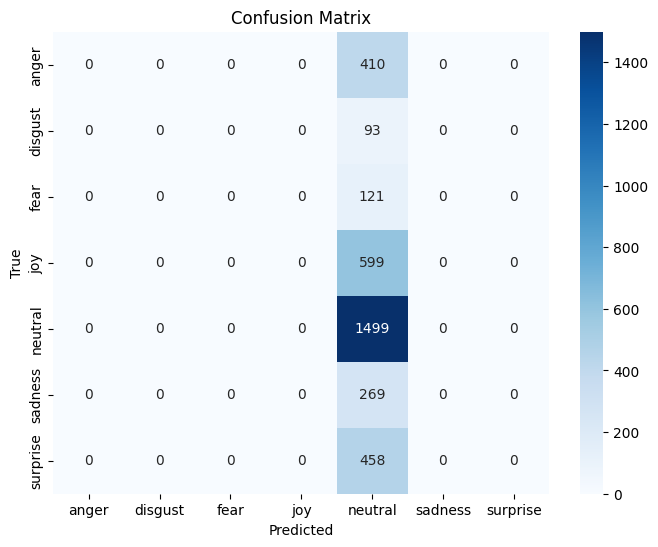

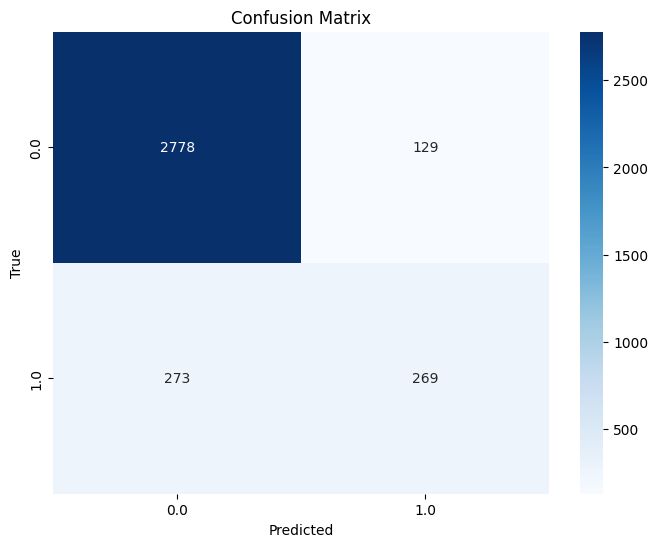

Metrics results in evaluating custom model
f1_seq_emotion: 0.4190589023568229
f1_flat_emotion: 0.43461873006668594
f1_seq_trigger: 0.8495509107265699
f1_flat_trigger: 0.8834444766599014



In [ ]:
custom_metrics = trainer_standard.test(custom_model, show_cm = True)
print_descriptive(custom_metrics, source= 'custom model')

In [ ]:
def generate_test_sample(df_standard, device, tokenizer, max_num_utterances):
    _, _, df_test = split_dataframe(df_standard, seed = 3)
    dataloader_test = create_dataloader(df_test, device, tokenizer, max_num_utterances, batch_size=1)
    dataiter = iter(dataloader_test)
    batch = next(dataiter)
    return batch

In [ ]:
# Generate two test samples
test_sample1 = generate_test_sample(df_standard, device, tokenizer, max_num_utterances)
test_sample2 = generate_test_sample(df_standard, device, tokenizer, max_num_utterances)

In [ ]:
def show_comparison(test_sample):
  test_dialogue = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(test_sample[1][0]))
  test_dialogue_splitted = test_dialogue.split('[SEP]')
  test_emotions = emotions_onehotencoder.inverse_transform(test_sample[3][0].cpu().numpy())
  test_triggers = test_sample[4][0]
  token_type_ids, input_ids, attention_mask, emotions, triggers = test_sample
  emotions_pred, trigger_pred, dialogue_mask = custom_model(token_type_ids, input_ids, attention_mask, emotions, triggers)
  emotions_pred_onehot = discrete_to_onehot(torch.argmax(emotions_pred, dim = -1)[0], num_classes = len(emotions_onehotencoder.classes_))
  emotions_pred_labels = emotions_onehotencoder.inverse_transform(emotions_pred_onehot)
  trigger_pred = (trigger_pred[0]>0.5).float()
  for idx, (utterance, emotion, emotion_pred, trigger, trigger_pred) in enumerate(zip(test_dialogue_splitted, test_emotions, emotions_pred_labels, test_triggers, trigger_pred)):
      if dialogue_mask[0][idx] != 0.0:
        print('From Speaker {speak_num}: {utterance}'.format( speak_num = token_type_ids[0][idx], utterance= utterance))
        print('Emotion: {emotion}. Emotion predicted: {emotion_pred}.'.format(emotion=emotion, emotion_pred=emotion_pred))
        print('Trigger: {trigger}. Trigger predicted: {trigger_pred}.'.format(trigger = trigger.item(), trigger_pred=trigger_pred.item()))
        print()

In this particular example, we observe that the predicted emotion consistently falls into the category of 'neutral'. This consistent prediction suggests that the trigger prediction process does not effectively leverage the information provided by the predicted emotion. Since the predicted emotion remains constant (always 'neutral'), the trigger prediction becomes independent of the emotional context. Consequently, the model may struggle to accurately predict the presence of triggers because it lacks the ability to relate changes in emotion (which remain constant) to trigger occurrences.


In [ ]:
show_comparison(test_sample1)

From Speaker 1: [CLS] hi . 
Emotion: neutral. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.

From Speaker 2:  hey . soaps ? shampoos ? are you really taking all this stuff ? 
Emotion: surprise. Emotion predicted: surprise.
Trigger: 0.0. Trigger predicted: 0.0.

From Speaker 1:  why not ? it ' s built into the price of the room . 
Emotion: neutral. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.

From Speaker 2:  yeah but you don ' t needwhat is this ? 
Emotion: surprise. Emotion predicted: surprise.
Trigger: 1.0. Trigger predicted: 0.0.

From Speaker 1:  thread ! 
Emotion: joy. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.



In [ ]:
show_comparison(test_sample2)

From Speaker 1: [CLS] i didn ' t even realise how late it was , until i noticed the 5 o ' clock shadow on her head . 
Emotion: neutral. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 0.0.

From Speaker 1:  anyway , she didn ' t want to stay . 
Emotion: sadness. Emotion predicted: neutral.
Trigger: 0.0. Trigger predicted: 1.0.

From Speaker 1:  i called a cab . she just left . 
Emotion: neutral. Emotion predicted: neutral.
Trigger: 1.0. Trigger predicted: 0.0.

